## Checking the Qutip Code

#### Imports and Data

In [1]:
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
import numpy as np
import qutip
from tqdm import tqdm, trange
from typing import Dict, List, Tuple, Union
import matplotlib.pyplot as plt

# size of the system
size: int = 6

# periodic boundary conditions
pbc: bool = True

# fix the random seed
np.random.seed(12)

# coupling term
j: float = 1.

#time 
tf=10.
dt=0.001


# time interval
t_resolution: int = int(tf / dt)
t: np.ndarray = np.linspace(0, tf, t_resolution)
print(t_resolution)
h0=0.
delta_h=1.
rate=1.


10000


#### Create the time independent Hamiltonian and the Initial state

In [2]:
ham0 = SpinHamiltonian(
            direction_couplings=[("z", "z")],
            field_directions=[("x"), ("z")],
            pbc=True,
            coupling_values=[0.0],
            field_values=[1.0, 0.],
            size=size,
        )


#print(ham0.qutip_op)


eng, psi0 = np.linalg.eigh(ham0.qutip_op)

psi0 = qutip.Qobj(
            psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(size)], [1]])
        )



Hermitian Check positive! well done! 

Hermitian Check positive! well done! 



#### Build the Local observable

In [3]:
obs: List[qutip.Qobj] = []
obs_x: List[qutip.Qobj] = []
for i in range(size):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=size, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    x_op = SpinOperator(index=[("x", i)], coupling=[1.0], size=size, verbose=1)
    print(z_op.expect_value(psi=psi0))
    obs.append(z_op.qutip_op)
    obs_x.append(x_op.qutip_op)

3.8510861166685117e-16
3.8510861166685117e-16
3.5735303605122226e-16
4.2674197509029455e-16
5.863365348801608e-16
2.671474153004283e-16


#### Let's make the Driving class

In [4]:
class DrivingUniformAnnealing:
    def __init__(
        self,
        t_resolution: int,
        dt: float,
        delta_h: float,
        rate: float,
    ) -> None:
        self.t_resolution = t_resolution
        self.dt = dt

        time = np.linspace(
            -self.dt * self.t_resolution / 2,
            self.dt * self.t_resolution / 2,
            self.t_resolution,
        )
        self.h = delta_h * (1 + np.tanh(time * rate)) / 2

    def field(self, t: float, args) -> Union[np.ndarray, float]:

        return self.h[int(t / self.dt) - 2]

#### Evolution

In [5]:
t: np.ndarray = np.linspace(0, tf, t_resolution)


h_qutip=np.zeros((t_resolution,size))
ham=[ham0.qutip_op]
for i in range(size):
    driving = DrivingUniformAnnealing(
                t_resolution=t_resolution,
                dt=dt,
                delta_h=delta_h,
                rate=rate,
            )
    h_qutip[:,i]=driving.h
    ham.append([obs[i], driving.field])
output = qutip.sesolve(ham, psi0, t, e_ops=obs + obs_x)

z_qutip=np.zeros((t_resolution,size))
for i in range(size):
        z_qutip[:,i] = output.expect[i]
        
    

#### Visualization

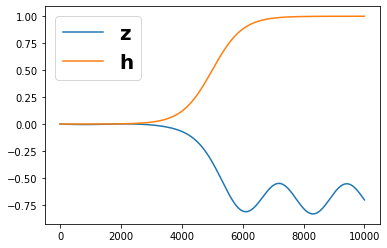

In [6]:
plt.plot(z_qutip[:,0],label=r'$\mathbf{z}$')
plt.plot(h_qutip[:,0],label=r'$\mathbf{h}$')
plt.legend(fontsize=20)
plt.show()

## Compare the Qutip Result with the Crack-Nicholson algorithm

#### Imports and Data (we need to use a different Environment)

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.tddft_methods.adiabatic_tddft import AdiabaticTDDFT

h_torch=torch.from_numpy(h_qutip)

Initial state configuration

In [8]:
psi=torch.zeros(size=(size,2),dtype=torch.complex128)
psi[:,1]=np.sqrt((1)/2)
psi[:,0]=np.sqrt((1)/2)

print(psi[:,0]**2-psi[:,1]**2)

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       dtype=torch.complex128)


Evolution (without gradient in order to check the algorithm)

In [9]:
run1=AdiabaticTDDFT(model=None,h=h_torch,omega=1.,device='cpu',with_grad=False)

z_adiabatic=torch.zeros(size=(t.shape[0],size))
z_adiabatic[0]=0.
grad=torch.zeros_like(z_adiabatic)
f=torch.zeros_like(torch.tensor(t))
for t in t[:-1]:
    #plt.plot(np.real(psi[:,0]))
    psi=run1.time_step(dt=dt,t=t,psi=psi)
    grad[int(t/dt)+1,:]=run1.grad
    f[int(t/dt)+1]=run1.f_values
    z_adiabatic[int(t/dt)+1,:]=run1.compute_magnetization(psi=psi)

/tmp/ipykernel_1595997/645568244.py:12: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/Copy.cpp:244.)
  z_adiabatic[int(t/dt)+1,:]=run1.compute_magnetization(psi=psi)


#### Visualization

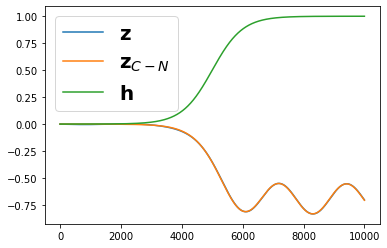

In [10]:
plt.plot(z_qutip[:,0],label=r'$\mathbf{z}$')
plt.plot(z_adiabatic[:,0].detach().numpy(),label=r'$\mathbf{z}_{C-N}$')
plt.plot(h_qutip[:,0],label=r'$\mathbf{h}$')
plt.legend(fontsize=20)
plt.show()

We checked that the Crank-Nicholson Algorithm works perfectely for $\Delta t=0.001$. We checked the result in this notebook.